In [1]:
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Input, Embedding, Reshape, merge, LSTM, Bidirectional
from keras.layers.core import Flatten, Dropout, Dense, Lambda
from keras.optimizers import SGD, RMSprop, Adam
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.
/usr/local/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
import pandas as pd
import numpy as np

%matplotlib inline

# init data

In [3]:
data = pd.read_csv('./train.csv')
print(data.shape)

(42000, 785)


In [4]:
X_data = data.iloc[:, 1:].values.astype('float32')
Y_data = data.iloc[:, 0].values.astype('float32')
print(type(X_data), X_data.shape)
print(type(Y_data), Y_data.shape)

<class 'numpy.ndarray'> (42000, 784)
<class 'numpy.ndarray'> (42000,)


In [5]:
X_data = X_data.reshape(X_data.shape[0], 28, 28, 1)
from keras.utils.np_utils import to_categorical
Y_data = to_categorical(Y_data)
num_classes = Y_data.shape[1]
print(type(X_data), X_data.shape)
print(type(Y_data), Y_data.shape)
print('num of classes:', num_classes)

<class 'numpy.ndarray'> (42000, 28, 28, 1)
<class 'numpy.ndarray'> (42000, 10)
num of classes: 10


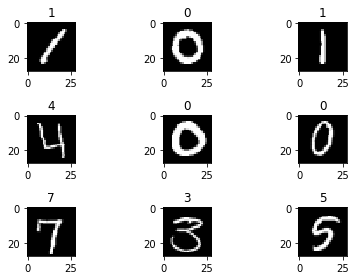

In [6]:
import matplotlib.pyplot as plt

for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    plt.imshow(X_data[i, :, :, 0], cmap=plt.get_cmap('gray'))
    plt.title(Y_data[i].argmax())
plt.tight_layout()

In [7]:
## split data to train and validation
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X_data, Y_data, test_size=0.1)
print(X_train.shape, Y_train.shape)
print(X_val.shape, Y_val.shape)

(37800, 28, 28, 1) (37800, 10)
(4200, 28, 28, 1) (4200, 10)


In [8]:
mean_px = X_train.mean().astype(np.float32)
std_px = X_train.std().astype(np.float32)
def norm_input(x): return (x-mean_px)/std_px

In [9]:
from keras.preprocessing import image
gen = image.ImageDataGenerator()
train_generator = gen.flow(X_train, Y_train, batch_size=64)
validation_generator = gen.flow(X_val, Y_val, batch_size=64)

# Linear Model

In [96]:
def get_linear_model():
    model = Sequential([
        Lambda(norm_input, input_shape=(28,28,1)),
        Flatten(),
        Dense(10, activation='softmax')
    ])
    model.compile(Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [97]:
lm = get_linear_model()

In [102]:
lm.fit_generator(train_generator, steps_per_epoch=20000, 
                 validation_data=validation_generator, validation_steps=10000, epochs=1)

Epoch 1/1
20000/20000 [==============================] - 81s 4ms/step - loss: 0.1988 - acc: 0.9424 - val_loss: 0.3856 - val_acc: 0.9052


# Single Dense Layer

In [112]:
def get_onedense_layer():
    model = Sequential([
        Lambda(norm_input, input_shape=(28,28,1)),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [113]:
onedense = get_onedense_layer()

In [114]:
onedense.fit_generator(train_generator, steps_per_epoch=20000, 
                 validation_data=validation_generator, validation_steps=10000, epochs=1)

Epoch 1/1
20000/20000 [==============================] - 280s 14ms/step - loss: 0.0241 - acc: 0.9924 - val_loss: 0.1466 - val_acc: 0.9781


# Basic VGG-style CNN

In [123]:
def get_cnn_model():
    model = Sequential([
        Lambda(norm_input, input_shape=(28,28,1)),
        Convolution2D(32, (3, 3), activation='relu'),
        Convolution2D(32, (3, 3), activation='relu'),
        MaxPooling2D(),
        Convolution2D(64, (3, 3), activation='relu'),
        Convolution2D(64, (3, 3), activation='relu'),
        MaxPooling2D(),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [124]:
model = get_cnn_model()

In [125]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_10 (Lambda)           (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 4, 4, 64)          0         
__________

In [127]:
model.fit_generator(train_generator, steps_per_epoch=1000, 
                 validation_data=validation_generator, validation_steps=1000, epochs=1)

Epoch 1/1
1000/1000 [==============================] - 283s 283ms/step - loss: 0.0264 - acc: 0.9914 - val_loss: 0.0495 - val_acc: 0.9840


In [128]:
model.optimizer.lr=0.001
model.fit_generator(train_generator, steps_per_epoch=1000, 
                 validation_data=validation_generator, validation_steps=1000, epochs=1)

Epoch 1/1
1000/1000 [==============================] - 280s 280ms/step - loss: 0.0188 - acc: 0.9940 - val_loss: 0.0700 - val_acc: 0.9807


# CNN + data augmentation

In [10]:
# data augmentation
gen = image.ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                               height_shift_range=0.08, zoom_range=0.08)
train_generator = gen.flow(X_train, Y_train, batch_size=64)
validation_generator = gen.flow(X_val, Y_val, batch_size=64)

In [135]:
model.optimizer.lr=0.001
model.fit_generator(train_generator, steps_per_epoch=1000, 
                 validation_data=validation_generator, validation_steps=1000, epochs=1)

Epoch 1/1
1000/1000 [==============================] - 240s 240ms/step - loss: 0.0341 - acc: 0.9894 - val_loss: 0.0513 - val_acc: 0.9851


# CNN + data augmentation + dropout + Batchnorm

In [11]:
def get_cnn_bn_do():
    model = Sequential([
        Lambda(norm_input, input_shape=(28,28,1)),
        Convolution2D(32, (3,3), activation='relu'),
        BatchNormalization(axis=1),
        Convolution2D(32, (3,3), activation='relu'),
        MaxPooling2D(),
        BatchNormalization(axis=1),
        Convolution2D(64, (3,3), activation='relu'),
        BatchNormalization(axis=1),
        Convolution2D(64, (3,3), activation='relu'),
        MaxPooling2D(),
        Flatten(),
        BatchNormalization(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(10, activation='softmax')
        ])
    model.compile(Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [12]:
model = get_cnn_bn_do()

In [36]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_3 (Lambda)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_11 (Batc (None, 26, 26, 32)        104       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 12, 12, 32)        48        
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 10, 10, 64)        18496     
__________

In [ ]:
model.fit_generator(train_generator, steps_per_epoch=1000, 
                    validation_data=validation_generator, epochs=1)

In [27]:
model.save_weights('models/cnn_bn_do.h5')

# check predictions

Keras' *fit()* function conveniently shows us the value of the loss function, and the accuracy, after every epoch ("*epoch*" refers to one full run through all training examples). The most important metrics for us to look at are for the validation set, since we want to check for over-fitting. 

- **Tip**: with our first model we should try to overfit before we start worrying about how to reduce over-fitting - there's no point even thinking about regularization, data augmentation, etc if you're still under-fitting! (We'll be looking at these techniques shortly).

As well as looking at the overall metrics, it's also a good idea to look at examples of each of:
1. A few correct labels at random
2. A few incorrect labels at random
3. The most correct labels of each class (ie those with highest probability that are correct)
4. The most incorrect labels of each class (ie those with highest probability that are incorrect)
5. The most uncertain labels (ie those with probability closest to 0.5).

In [29]:
result = model.predict_on_batch(X_val)

In [30]:
print(result.shape)
print(Y_val.shape)
our_labels = result.argmax(axis=1)
expected_labels = Y_val.argmax(axis=1)
print(our_labels.shape)
print(expected_labels.shape)

(4200, 10)
(4200, 10)
(4200,)
(4200,)


In [31]:
from numpy.random import permutation

def plots_idx(idx, titles=None):
    for i in range(len(idx)):
        ix = idx[i]
        plt.subplot(3, 3, i+1)
        plt.imshow(X_val[ix, :, :, 0], cmap=plt.get_cmap('gray'))
        plt.title(titles[ix])
    plt.tight_layout()

n_view = 9

Found 4171 correct labels


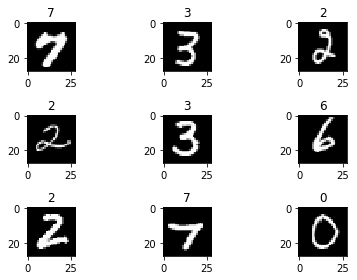

In [32]:
#1. A few correct labels at random
correct = np.where(our_labels==expected_labels)[0]
print("Found %d correct labels" % len(correct))
idx = permutation(correct)[:n_view]
plots_idx(idx, our_labels)

Found 29 incorrect labels


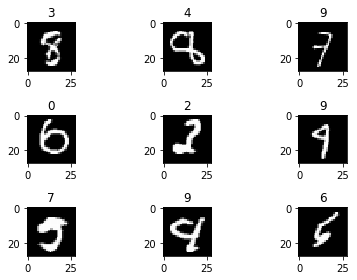

In [33]:
#2. A few incorrect labels at random
correct = np.where(our_labels!=expected_labels)[0]
print("Found %d incorrect labels" % len(correct))
idx = permutation(correct)[:n_view]
plots_idx(idx, our_labels)

# import test data

In [15]:
test_data = pd.read_csv('./test.csv')
print(test_data.shape)

(28000, 784)


In [16]:
X_test = test_data.values.astype('float32')
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
print(type(X_test), X_test.shape)

<class 'numpy.ndarray'> (28000, 28, 28, 1)


# Pseudo labeling

We're going to try using a combination of [pseudo labeling](http://deeplearning.net/wp-content/uploads/2013/03/pseudo_label_final.pdf) and [knowledge distillation](https://arxiv.org/abs/1503.02531) to allow us to use unlabeled data (i.e. do semi-supervised learning). For our initial experiment we'll use the validation set as the unlabeled data, so that we can see that it is working without using the test set. At a later date we'll try using the test set.

In [ ]:
Y_test = model.predict_on_batch(X_test)

In [ ]:
X_comb = np.concatenate([X_train, X_test])
Y_comb = np.concatenate([Y_train, Y_test])

In [ ]:
# bn_model.load_weights('models/da_conv8_1.h5')

In [ ]:
model.fit(X_comb, Y_comb, batch_size=batch_size, nb_epoch=1,
             validation_data=(X_val, Y_val))

In [ ]:
model.save_weights('models/bn-ps8.h5')

# Ensembling

In [ ]:
def fit_model():
    model = get_cnn_bn_do()
    model.fit_generator(train_generator, steps_per_epoch=1000, 
                 validation_data=validation_generator, validation_steps=1000, epochs=15)
    return model

In [ ]:
models = [fit_model() for i in range(6)]

In [ ]:
model_path = 'models/'
for i,m in enumerate(models):
    m.save_weights(model_path+'cnn-mnist-'+str(i)+'.pkl')

In [ ]:
all_preds = np.stack([m.predict(X_val, batch_size=256) for m in models])
print(all_preds.shape)

In [ ]:
avg_preds = all_preds.mean(axis=0)
keras.metrics.categorical_accuracy(y_val, avg_preds).eval()

# submit

In [13]:
model.load_weights('models/cnn_bn_do.h5')

In [17]:
predictions = model.predict(X_test, batch_size=64)
print(predictions.shape)

(28000, 10)


In [ ]:
predictions = predictions.argmax(axis=1)

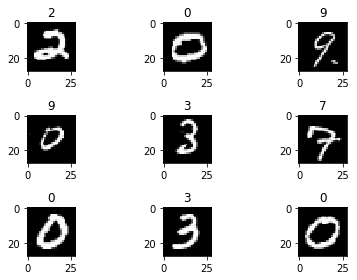

In [22]:
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    plt.imshow(X_test[i, :, :, 0], cmap=plt.get_cmap('gray'))
    plt.title(predictions[i])
plt.tight_layout()

In [19]:
submissions=pd.DataFrame({"ImageId": list(range(1,len(predictions)+1)),
                         "Label": predictions})
submissions.to_csv("cnn_bn_do_1.csv", index=False, header=True)